In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import heatmap
import seaborn as sns

# Data Info

## Features
- quality_variation: consisting of a number 0 (L), 1 (M), or 2 (H) for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

## Outcomes
- machine failure: indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true
- tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
- heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
- power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
- overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
- random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

The goal of this synthetic dataset seems to be explainability for why a machine has failed. When a machine has failed (machine_failure == 1), any number of the indicated failure modes could have caused it. 

# Load Training Data

In [ ]:
X_train = pd.read_csv("./data/X_train.csv")
X_train.columns = ['quality_variation', 'air_temp', 'process_temp', 'rot_speed', 'torque', 'tool_wear']
display(X_train)
X_train.dtypes

,quality_variation,air_temp,process_temp,rot_speed,torque,tool_wear
0,0,298.0,308.3,1473,42.6,107
1,0,300.5,310.5,1373,47.4,56
2,1,301.0,310.7,1493,48.1,145
3,0,300.8,310.7,1461,42.8,173
4,1,304.1,313.2,1586,41.1,129
...,...,...,...,...,...,...
7494,1,297.3,308.1,1369,52.0,214
7495,1,302.2,311.2,1561,34.9,106
7496,0,296.8,307.9,1489,33.4,123
7497,0,298.3,309.1,1616,31.1,195


quality_variation      int64
air_temp             float64
process_temp         float64
rot_speed              int64
torque               float64
tool_wear              int64
dtype: object

In [21]:
Y_train = pd.read_csv("./data/Y_train.csv")
Y_train.columns = ['machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf']
display(Y_train)
print(Y_train.dtypes)

,machine_failure,twf,hdf,pwf,osf,rnf
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
7494,0,0,0,0,0,0
7495,0,0,0,0,0,0
7496,0,0,0,0,0,0
7497,0,0,0,0,0,0


machine_failure    int64
twf                int64
hdf                int64
pwf                int64
osf                int64
rnf                int64
dtype: object


In [22]:
training_data = pd.concat([X_train, Y_train], axis=1)
display(training_data)

,quality_variation,air_temp,process_temp,rot_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf
0,0,298.0,308.3,1473,42.6,107,0,0,0,0,0,0
1,0,300.5,310.5,1373,47.4,56,0,0,0,0,0,0
2,1,301.0,310.7,1493,48.1,145,0,0,0,0,0,0
3,0,300.8,310.7,1461,42.8,173,0,0,0,0,0,0
4,1,304.1,313.2,1586,41.1,129,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7494,1,297.3,308.1,1369,52.0,214,0,0,0,0,0,0
7495,1,302.2,311.2,1561,34.9,106,0,0,0,0,0,0
7496,0,296.8,307.9,1489,33.4,123,0,0,0,0,0,0
7497,0,298.3,309.1,1616,31.1,195,0,0,0,0,0,0


# EDA

In [23]:
print(training_data.dtypes)
print(training_data.nunique())

quality_variation      int64
air_temp             float64
process_temp         float64
rot_speed              int64
torque               float64
tool_wear              int64
machine_failure        int64
twf                    int64
hdf                    int64
pwf                    int64
osf                    int64
rnf                    int64
dtype: object
quality_variation      3
air_temp              93
process_temp          82
rot_speed            882
torque               555
tool_wear            245
machine_failure        2
twf                    2
hdf                    2
pwf                    2
osf                    2
rnf                    2
dtype: int64


In [25]:
training_data[training_data['machine_failure'] == 1]

,quality_variation,air_temp,process_temp,rot_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf
44,0,298.3,309.3,1337,56.1,206,1,0,0,0,1,0
49,0,302.0,309.9,1308,57.6,197,1,0,1,0,1,0
110,0,300.4,311.8,1272,59.2,198,1,0,0,0,1,0
119,0,302.5,310.2,1329,50.6,148,1,0,1,0,0,0
133,0,300.5,309.3,1417,51.5,231,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7332,0,297.8,309.0,1403,64.2,0,1,0,0,1,0,0
7339,0,301.2,311.6,1461,52.9,208,1,0,0,0,1,0
7384,1,303.0,311.1,1372,54.3,117,1,0,1,0,0,0
7414,0,303.2,311.4,1351,53.8,8,1,0,1,0,0,0


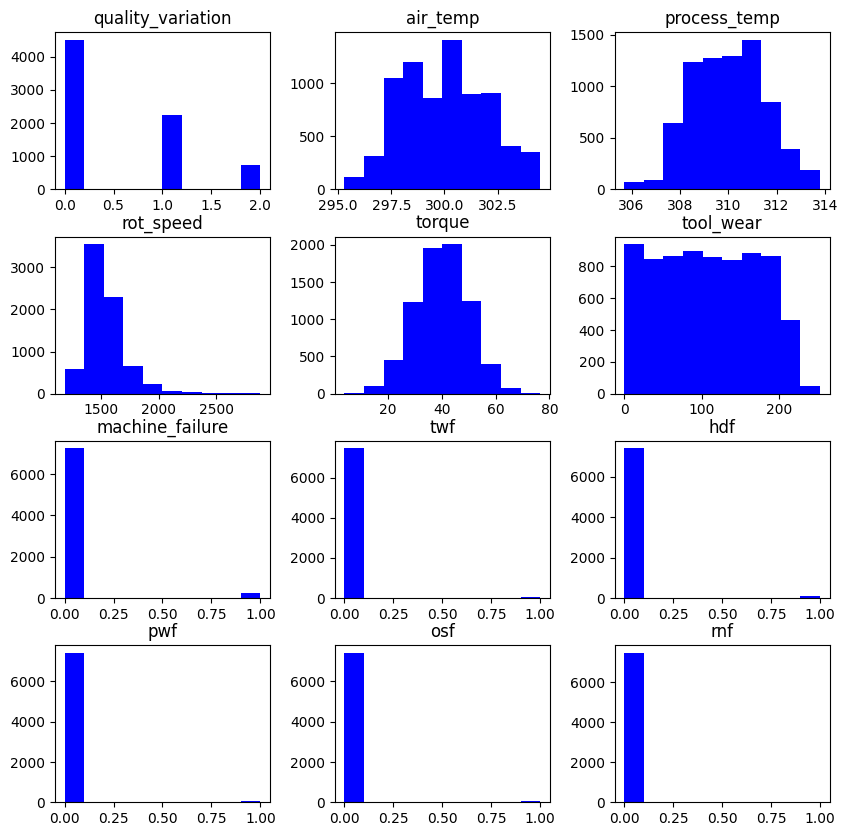

In [27]:
fig = training_data.hist(figsize=(10, 10),color = 'blue', grid=False)
plt.show()

In [ ]:
# Failure frequency by failure category bar chart
failure_counts.plot(kind='bar')
plt.title("Failure Type Counts")
plt.ylabel("Occurrences")
plt.show()

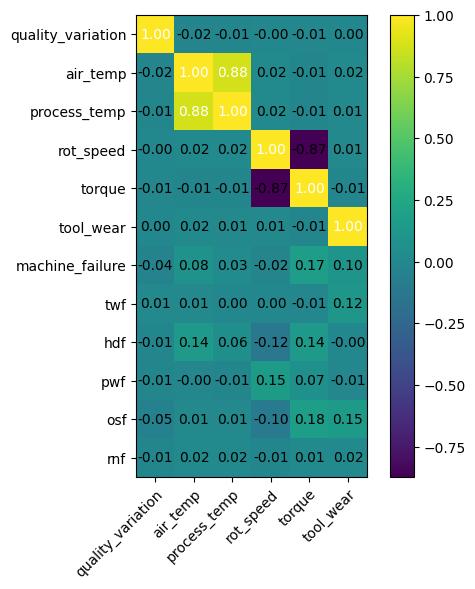

In [29]:
cm = training_data.corr()[['quality_variation', 'air_temp', 'process_temp', 'rot_speed', 'torque', 'tool_wear']]

hm = heatmap(
    cm.values,
    row_names=cm.index,
    column_names=cm.columns,
    figsize=(6, 6)
)
plt.show()

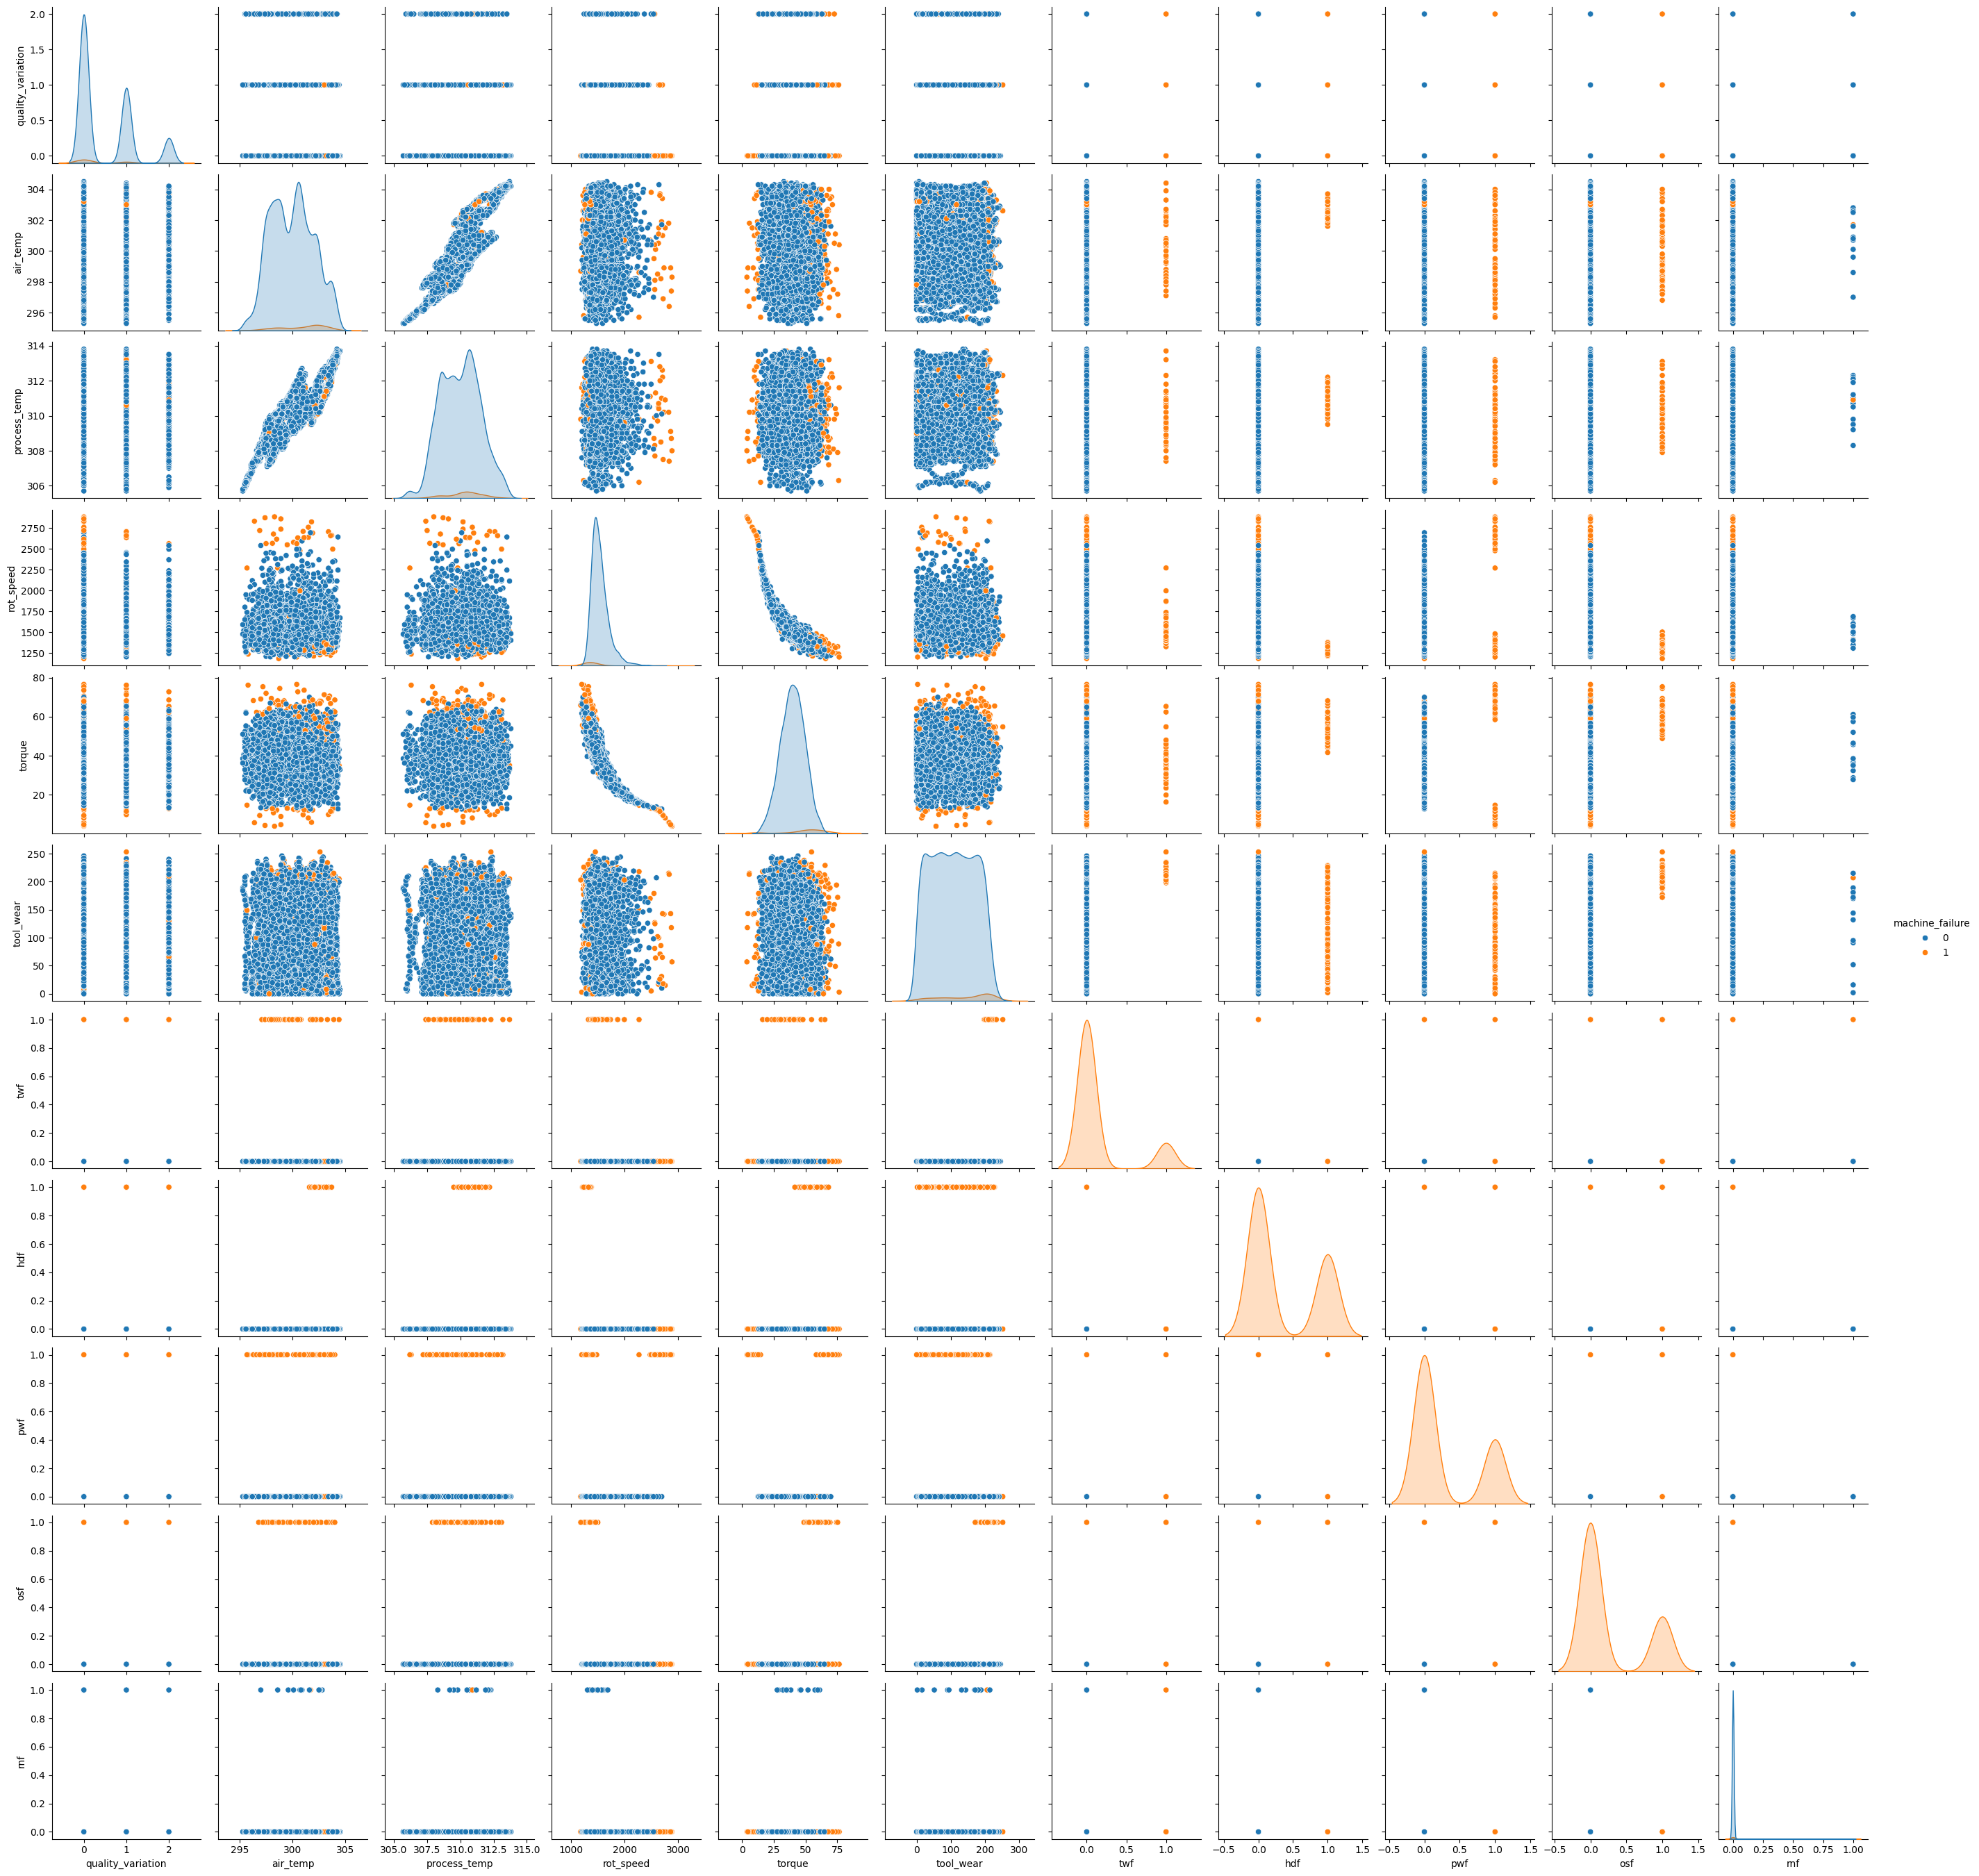

In [36]:
sns.pairplot(training_data, hue='machine_failure')
plt.show()

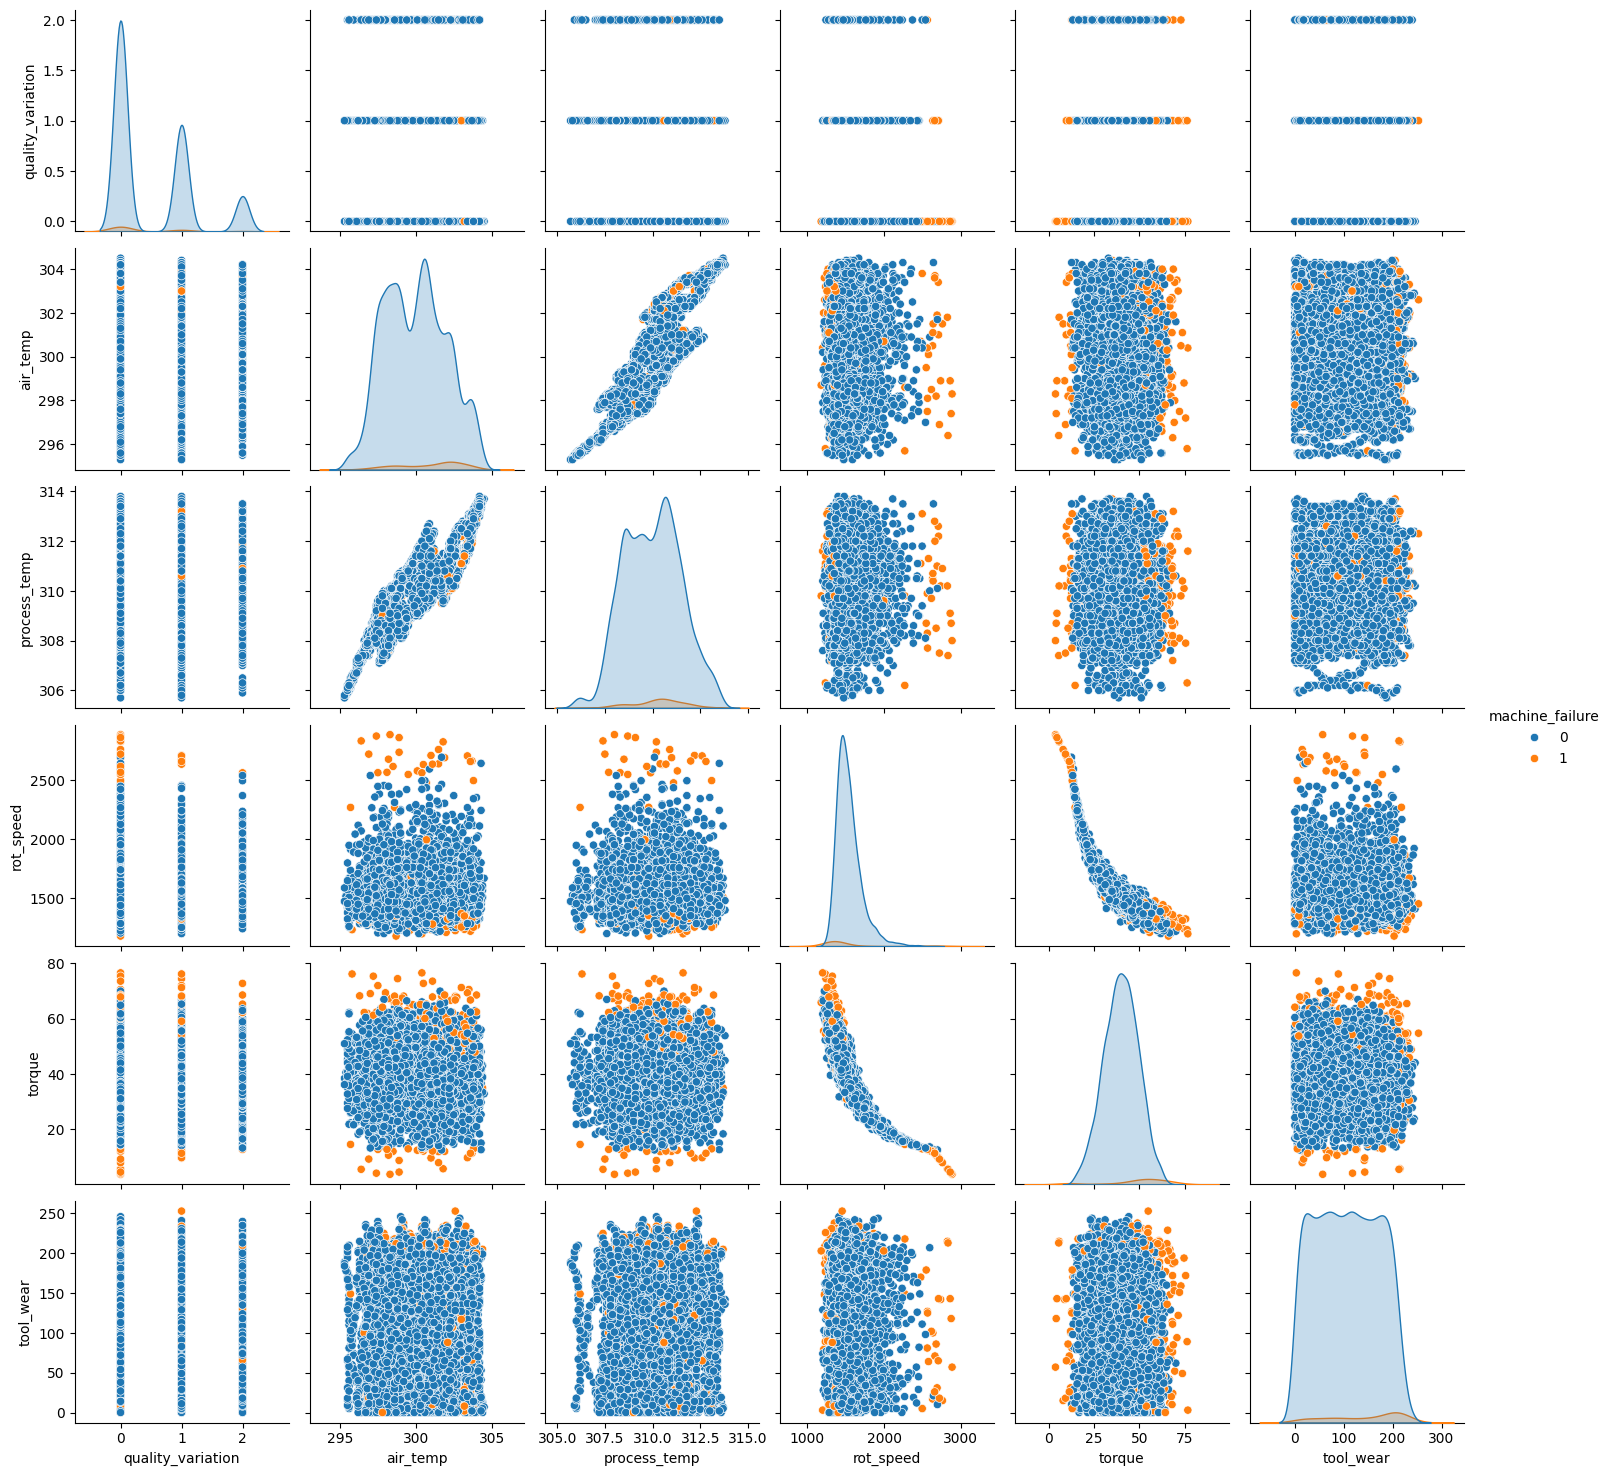

In [34]:
sns.pairplot(training_data[['quality_variation', 'air_temp', 'process_temp', 'rot_speed', 'torque', 'tool_wear', 'machine_failure']], hue='machine_failure')
plt.show()

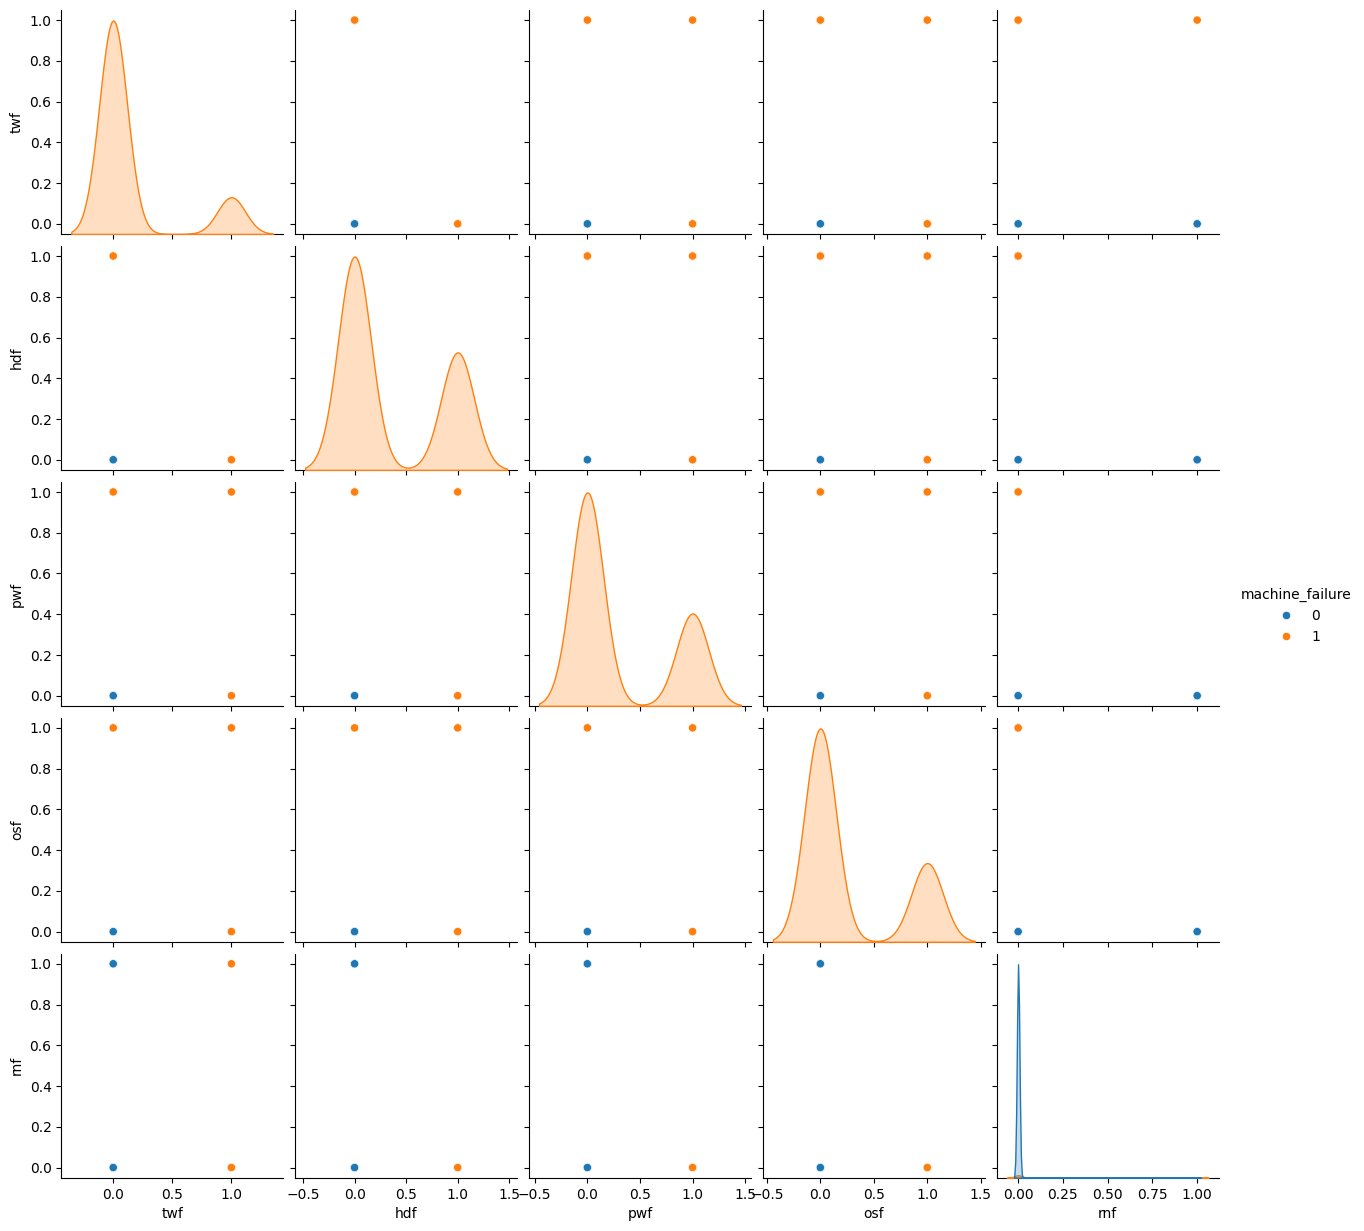

In [35]:
sns.pairplot(training_data[['machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf']], hue='machine_failure')
plt.show()